<a href="https://colab.research.google.com/github/cpvivek/Facial-Emotion-Recognition/blob/main/Capstone_DL%26MLE_Facial_Emotion_Recognition_Vivek_CP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Emotion Detection
The objective of this project is to develop a CNN model to perform facial emotion recognition on human faces, and deploy a web app to perform this task in real time.

Importing necessary libraries including tensorflow, keras, sklearn and opencv

In [ ]:
# import necessary files
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import keras
import tensorflow as tf
from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten

Importing dataset sourced from kaggle

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


reading the csv file.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Alma Better Pro/Alma Better Pro Program/Module 4: Machine Learning/Data Sets/icml_face_data.csv')

#EDA

Let's look into our dataset

In [ ]:
df.columns

Index(['emotion', ' Usage', ' pixels'], dtype='object')

So the dataset is not all that complicated.

We've got 'emotion' field indicating different emotions.

I believe since this is a dataset used in kaggle competitions, they've went ahead and done the training, validation and test segregation, labeled by 'Usage' column

And finally in the 'pixels' field, we have the pixelated form of the image, flattened into an 1 dimension array. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1    Usage   35887 non-null  object
 2    pixels  35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


The pixel field is stored as a string at the moment. We'll have to convert that into a 48x48x1 array with float values.

In [ ]:
#using lambda function to achieve this conversion
df[' pixels']=df[' pixels'].apply(lambda x: np.fromstring(x, sep=' ',dtype='float32')) #converting string to float separated by ' ' 
df[' pixels']=df[' pixels'].apply(lambda x:np.asarray(x.reshape(48,48,1))) #reshaping to 48x48x1

Let's look into emotions field.

In [ ]:
df['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

The dataset contains 7 different emotions labeled using number from 0 to 6.

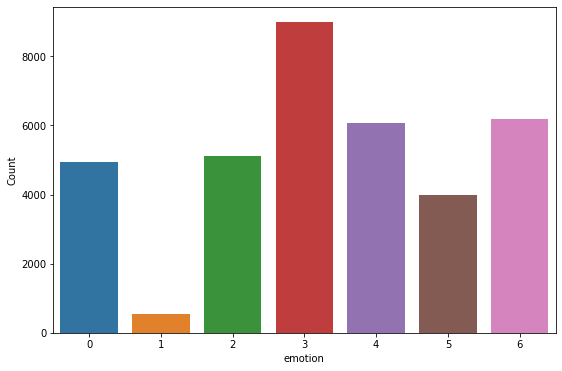

In [ ]:
emotion_count=df.groupby('emotion').count().rename(columns={' Usage':'Count'}).drop(' pixels',axis=1).reset_index()
plt.figure(figsize=(9,6))
sns.barplot(x=emotion_count['emotion'],y=emotion_count['Count'])
plt.show()

We can observe that the number of images corresponding to each images is quite imbalanced.This will create an bias in model towards certain emotions.
So we'd have to perform some image augmentation in the training set to tackle this issue.

Let's segregate our training, validation and test sets right away. 

Public Test would be put into validation and Private test into test set. 

In [ ]:
df[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

In [ ]:
#defininng train, val and test data.
training_data=df[df[' Usage']=='Training']
validation_data=df[df[' Usage']=='PublicTest']
testing_data=df[df[' Usage']=='PrivateTest']

In [ ]:
training_data['emotion'].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

x_train, y_train formation


In [ ]:
x_train=[]
for i in range(len(training_data[' pixels'])):
  x_train.append(training_data[' pixels'][i])
x_train=np.asarray(x_train) #since we need arrays as input to CNN 
x_train=x_train.reshape(len(x_train),48,48,1)
y_train=np.array(training_data['emotion'])
y_train=y_train.astype(int)
y_train=np_utils.to_categorical(y_train,7)
# shape of training data
x_train.shape, y_train.shape

((28709, 48, 48, 1), (28709, 7))

x_val, y_val

In [ ]:
x_val = []
for i in validation_data[' pixels']:
  x_val.append(i)
x_val=np.asarray(x_val)
x_val= x_val.reshape(len(x_val),48,48,1)
y_val=np.array(validation_data['emotion'])
y_val=y_val.astype(int)
y_val=np_utils.to_categorical(y_val,7)



x_val.shape,y_val.shape

((3589, 48, 48, 1), (3589, 7))

x_test, y_test

In [ ]:
x_test = []

for i in testing_data[' pixels']:
  x_test.append(i)
x_test=np.array(x_test)
x_test=x_test.reshape(len(x_test),48,48,1)
y_test=np.array(testing_data['emotion'])
y_test=y_test.astype(int)
y_test=np_utils.to_categorical(y_test,7)
# code here

# then check shape
x_test.shape,y_test.shape

((3589, 48, 48, 1), (3589, 7))

In [ ]:
from google.colab.patches import cv2_imshow

Let's have  a look at few of the pictures in the training set

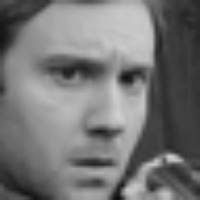

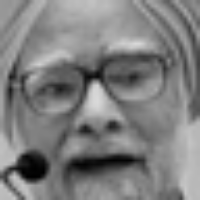

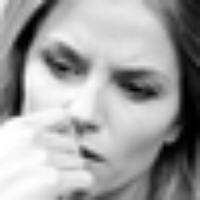

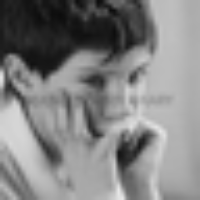

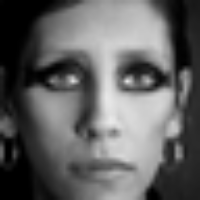

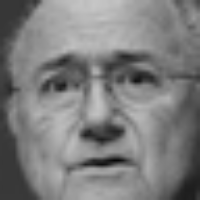

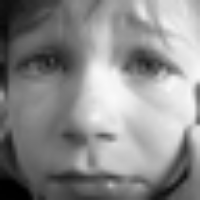

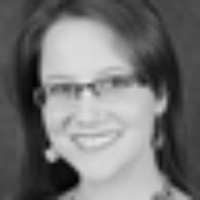

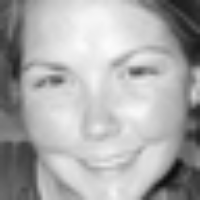

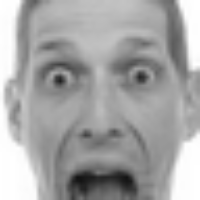

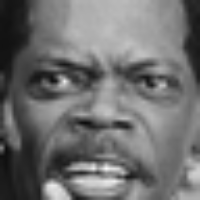

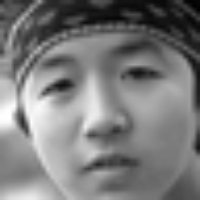

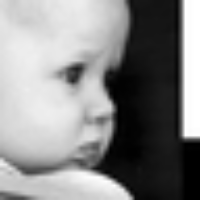

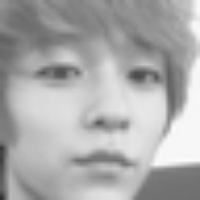

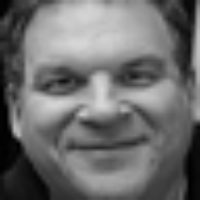

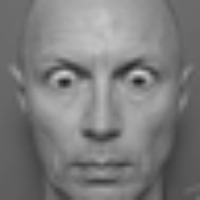

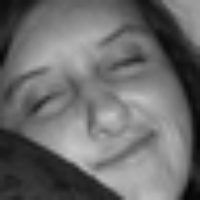

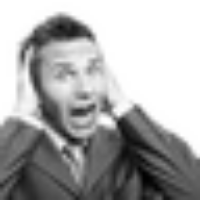

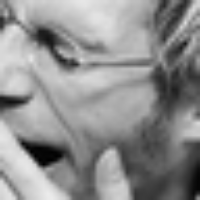

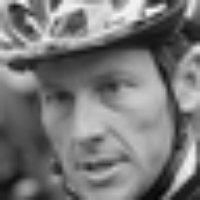

In [ ]:
for x in x_train[:20]:
  px=x.reshape(48,48)
  px=cv2.resize(px,(200,200))
  cv2_imshow(px)

#Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen= ImageDataGenerator(
    rescale=1./255, #rescaling
    rotation_range=10,#rotating the image
    horizontal_flip=True,#flipping the image horizontally
    width_shift_range=0.1,
    height_shift_range=0.1, #shift in width and height
    fill_mode='nearest'
)
valgen=ImageDataGenerator(rescale=1./255)
testgen= ImageDataGenerator(rescale=1./255)

In [ ]:
datagen.fit(x_train)

In [ ]:
train_flow=datagen.flow(x_train,y_train,batch_size=64)#augmenting training set images.
val_flow=valgen.flow(x_val,y_val,batch_size=64) #normalizing val and test dataset.
test_flow=testgen.flow(x_test,y_test,batch_size=64)

#Building models using keras layers and keras sequential model

In [ ]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 7.3 MB/s 


In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from visualkeras import layered_view, graph_view
from keras.callbacks import EarlyStopping

#Model 1

In [ ]:
model_fer_1=Sequential()

#1st Block
model_fer_1.add(Conv2D(32, kernel_size=3, strides=(1,1),activation='relu',input_shape=(48,48,1))) #Convolution layer
model_fer_1.add(MaxPooling2D(pool_size=(2,2)))#Maxpooling layer
model_fer_1.add(BatchNormalization())#Batch Normalisation

#2nd Block
model_fer_1.add(Conv2D(64, kernel_size=3, strides=(1,1),activation='relu'))
model_fer_1.add(MaxPooling2D(pool_size=(2,2)))
model_fer_1.add(BatchNormalization())

#3rd Block
model_fer_1.add(Conv2D(128, kernel_size=3,strides=(1,1), activation='relu'))
model_fer_1.add(MaxPooling2D(pool_size=(2,2)))
model_fer_1.add(BatchNormalization())

#Flatten and output
model_fer_1.add(Flatten()) #Flattening the matrix
model_fer_1.add(Dense(480, activation='relu'))
model_fer_1.add(Dense(240, activation='relu'))
model_fer_1.add(Dense(7, activation='softmax'))#Final output of 7 nodes

In [ ]:
#compiling the model
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model_fer_1.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
model_fer_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


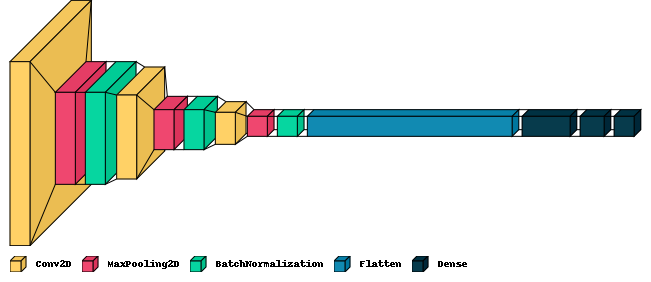

In [ ]:
#visual representation of model
layered_view(model_fer_1,legend=True)

Note:
this model architecture is inspired from analyticsvidhya.com

https://www.analyticsvidhya.com/blog/2021/11/facial-emotion-detection-using-cnn/

In [ ]:
num_epochs = 200
early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)#early stopping upon no improvement over 15 epochs
history = model_fer_1.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow,
                    callbacks=[early_stopping])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/200
448/448 [==============================] - 24s 28ms/step - loss: 1.7146 - accuracy: 0.3256 - val_loss: 1.7754 - val_accuracy: 0.2898
Epoch 2/200
448/448 [==============================] - 12s 28ms/step - loss: 1.5630 - accuracy: 0.3984 - val_loss: 1.4529 - val_accuracy: 0.4425
Epoch 3/200
448/448 [==============================] - 13s 28ms/step - loss: 1.4673 - accuracy: 0.4353 - val_loss: 1.4238 - val_accuracy: 0.4606
Epoch 4/200
448/448 [==============================] - 12s 27ms/step - loss: 1.4074 - accuracy: 0.4623 - val_loss: 1.3404 - val_accuracy: 0.4887
Epoch 5/200
448/448 [==============================] - 13s 29ms/step - loss: 1.3589 - accuracy: 0.4803 - val_loss: 1.3335 - val_accuracy: 0.4926
Epoch 6/200
448/448 [==============================] - 13s 28ms/step - loss: 1.3153 - accuracy: 0.4987 - val_loss: 1.2865 - val_accuracy: 0.5029
Epoch 7/200
448/448 [==============================] - 14s 31ms/step - loss: 1.2844 - accuracy: 0.5116 - val_loss: 1.2240 - val_ac

In [88]:
#saving model parameters to disk
model_json = model_fer_1.to_json()
with open("model_fer_1.json", "w") as json_file:
    json_file.write(model_json)
model_fer_1.save_weights("model_fer_1.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#loading saved model
from tensorflow.keras.models import model_from_json
model = model_from_json(open("/content/model_fer_1.json", "r").read())
model.load_weights('model_fer_1.h5')
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [ ]:
#total loss and accuracy in training the dataset on test set
score = model.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)

113/113 [==============================] - 1s 4ms/step - loss: 1.0325 - accuracy: 0.6155
Test Loss:  1.0324616432189941
Test Accuracy:  61.54918074607849


The model has given out mediocre scores in the test set. There seems to high bias, high variance situation here. 
Next models has to be deeper.

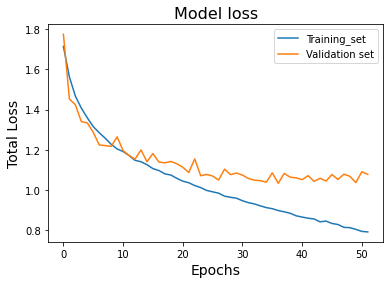

In [ ]:
#plotting training, validation loss over epochs
plt.plot(history.history['loss'], label="Training_set")
plt.plot(history.history['val_loss'], label="Validation set")
plt.title("Model loss", size=16)
plt.ylabel("Total Loss", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

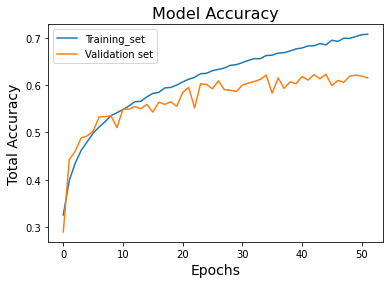

In [ ]:
#plotting training, validation accuracy over number of epochs
plt.plot(history.history['accuracy'], label="Training_set")
plt.plot(history.history['val_accuracy'], label="Validation set")
plt.title("Model Accuracy", size=16)
plt.ylabel("Total Accuracy", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

In [ ]:
from keras.preprocessing import image
def pred_emotion(img_path):
  ''' This function takes in an image and predicts the emotion'''
  emotion_dict = {0: 'Angry', 1: 'Disgusted', 2: 'Fearful', 3: 'Happy', 4: 'Sad',5: 'Suprised', 6: 'Neutral'}
  
  img = image.load_img(img_path, grayscale=True, target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model_fer_1.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : Angry


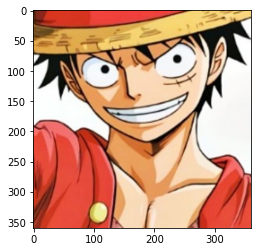

In [ ]:
#predicting emotion
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/image1.jpg")

The picture should ideally be labelled as happy. But one can see the logic in misclassification here. The model is probably associating the visibility of teeths with anger.

113/113 [==============================] - 1s 4ms/step


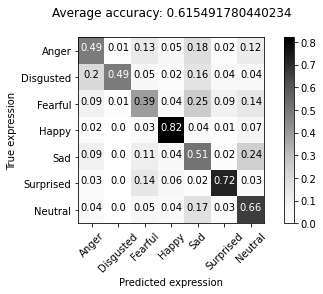

In [ ]:
classes=np.array(("Anger", "Disgusted", "Fearful", "Happy", "Sad", "Surprised", "Neutral"))
import itertools 
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model_fer_1.predict(x_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

**Remarks**


The model has best accuracy at detecting happy and surprised emotions. Fear, disgust and anger on the other hand are giving the model a hard time. 

The model has low training set accuracy. We should deepen the network a bit.

There is considerable gap between training and test accuracies, indicating presence of overfitting.  We should try implimenting some regularization in next models.

#Model 2

In [ ]:
#designing the model
#I've increased the depth of the network, and introduced dropout layers with p=0.5

model_fer_2 = Sequential()

model_fer_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model_fer_2.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_2.add(BatchNormalization())
model_fer_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_2.add(Dropout(0.5))

model_fer_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_2.add(BatchNormalization())
model_fer_2.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_2.add(BatchNormalization())
model_fer_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_2.add(Dropout(0.5))

model_fer_2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_2.add(BatchNormalization())
model_fer_2.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_2.add(BatchNormalization())
model_fer_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_2.add(Dropout(0.5))

model_fer_2.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_2.add(BatchNormalization())
model_fer_2.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_2.add(BatchNormalization())
model_fer_2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_2.add(Dropout(0.5))

model_fer_2.add(Flatten())

model_fer_2.add(Dense(512, activation='relu'))
model_fer_2.add(Dropout(0.4))
model_fer_2.add(Dense(256, activation='relu'))
model_fer_2.add(Dropout(0.4))
model_fer_2.add(Dense(128, activation='relu'))
model_fer_2.add(Dropout(0.5))
model_fer_2.add(Dense(7, activation='softmax'))
model_fer_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 conv2d_15 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_13 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 23, 23, 128)      

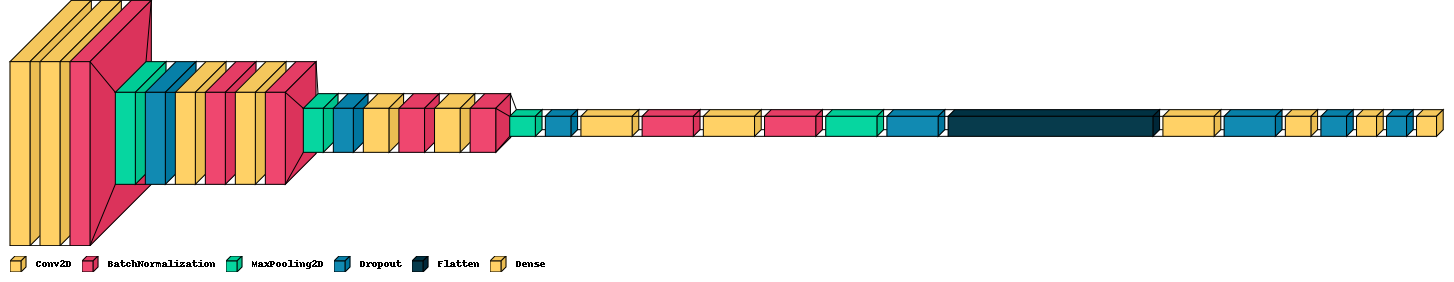

In [ ]:
#visual representation of the model
layered_view(model_fer_2,legend=True)

In [ ]:
#compiling the model
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=1e-6)
model_fer_2.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [ ]:
#fitting the model on the training dataset
num_epochs = 100
early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)#early stopping upon no improvement over 15 epochs
history = model_fer_2.fit(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1, 
                    callbacks=[early_stopping], 
                    validation_data=test_flow)


Epoch 1/100
448/448 [==============================] - 25s 50ms/step - loss: 2.3378 - accuracy: 0.1786 - val_loss: 1.8396 - val_accuracy: 0.2449
Epoch 2/100
448/448 [==============================] - 21s 46ms/step - loss: 1.9129 - accuracy: 0.2032 - val_loss: 1.8207 - val_accuracy: 0.2449
Epoch 3/100
448/448 [==============================] - 23s 51ms/step - loss: 1.8694 - accuracy: 0.2146 - val_loss: 1.8199 - val_accuracy: 0.2452
Epoch 4/100
448/448 [==============================] - 26s 58ms/step - loss: 1.8468 - accuracy: 0.2256 - val_loss: 1.8129 - val_accuracy: 0.2449
Epoch 5/100
448/448 [==============================] - 22s 49ms/step - loss: 1.8358 - accuracy: 0.2335 - val_loss: 1.8091 - val_accuracy: 0.2449
Epoch 6/100
448/448 [==============================] - 20s 46ms/step - loss: 1.8294 - accuracy: 0.2345 - val_loss: 1.8143 - val_accuracy: 0.2449
Epoch 7/100
448/448 [==============================] - 20s 46ms/step - loss: 1.8225 - accuracy: 0.2371 - val_loss: 1.7981 - val_ac

In [ ]:
#saving the model to disk
model_json = model_fer_2.to_json()
with open("model_fer_2.json", "w") as json_file:
    json_file.write(model_json)
model_fer_2.save_weights("model_fer_2.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
#loading model
model = model_from_json(open("/content/model_fer_2.json", "r").read())
model.load_weights('model_fer_2.h5')
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#total loss and accuracy in training the dataset on test set
score = model_fer_2.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)
      

113/113 [==============================] - 2s 11ms/step - loss: 0.9151 - accuracy: 0.6565
Test Loss:  0.9150729179382324
Test Accuracy:  65.64502716064453


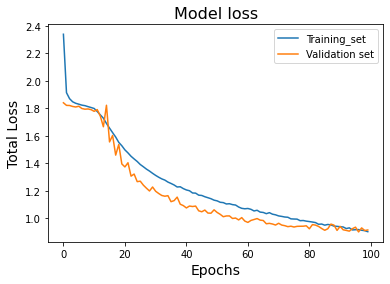

In [ ]:
plt.plot(history.history['loss'], label="Training_set")
plt.plot(history.history['val_loss'], label="Validation set")
plt.title("Model loss", size=16)
plt.ylabel("Total Loss", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

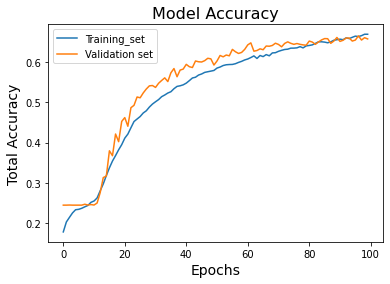

In [ ]:
plt.plot(history.history['accuracy'], label="Training_set")
plt.plot(history.history['val_accuracy'], label="Validation set")
plt.title("Model Accuracy", size=16)
plt.ylabel("Total Accuracy", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

113/113 [==============================] - 1s 8ms/step


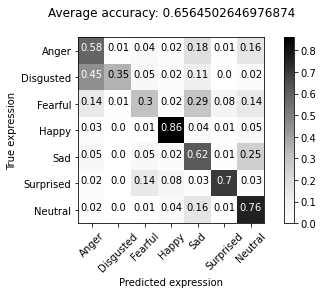

In [ ]:
classes=np.array(("Anger", "Disgusted", "Fearful", "Happy", "Sad", "Surprised", "Neutral"))
import itertools 
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model_fer_2.predict(x_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

The test accuracy has improved by deploying dropout regularization, but the training set accuracy has dropped. 

It still is most comfortable with happy and surprised emotions. The accuracy with sad, angry and neutral images has improved as wel, but not satisfactory. Let's look at few predictions of the model



In [ ]:
from keras.preprocessing import image
def pred_emotion(img_path):
  emotion_dict = {0: 'Angry', 1: 'Disgusted', 2: 'Fearful', 3: 'Happy', 4: 'Sad',5: 'Surprised', 6: 'Neutral'}
  img = image.load_img(img_path, grayscale=True, target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model_fer_2.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : Happy


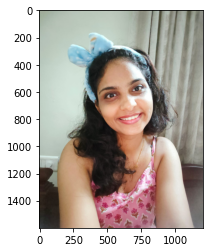

In [ ]:
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/happy aishu2.jfif")

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : Angry


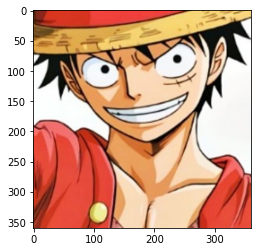

In [ ]:
pred_emotion('/content/drive/MyDrive/Cloudy ML/opencv/image1.jpg')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : Happy


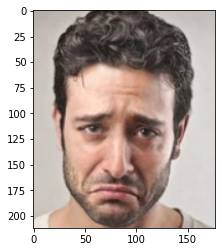

In [ ]:
pred_emotion('/content/drive/MyDrive/Cloudy ML/opencv/sad.jpg')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : Happy


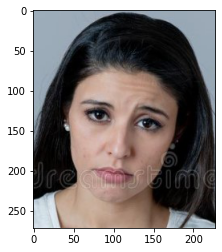

In [ ]:
pred_emotion('/content/drive/MyDrive/Cloudy ML/opencv/sad2.jpg')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : Happy


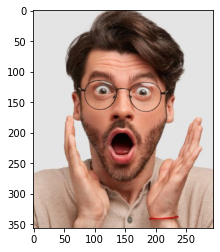

In [ ]:
pred_emotion('/content/drive/MyDrive/Cloudy ML/opencv/surpirsed.jpg')

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


The predicted emotion is : Happy


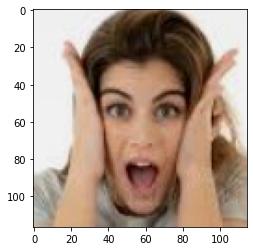

In [ ]:
pred_emotion('/content/drive/MyDrive/Cloudy ML/opencv/surprise2.jpg')

**Remarks**

The val set accuracy has improved but the training set accuracy has dropped.

I shall try different p values for dropouts to improve the training accuracies.

This model is biased towards happy emotion, and is misclassifying a lot of sad and surprised emotions as happy.

#Model 3

Let's try varying the dropout threshold in this model

In [ ]:
#This model is pretty much the same as the last one, but the dropout thresholds have been brought down a little.
model_fer_3 = Sequential()

model_fer_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model_fer_3.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_3.add(BatchNormalization())
model_fer_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_3.add(Dropout(0.25))

model_fer_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_3.add(BatchNormalization())
model_fer_3.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_3.add(BatchNormalization())
model_fer_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_3.add(Dropout(0.3))

model_fer_3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_3.add(BatchNormalization())
model_fer_3.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_3.add(BatchNormalization())
model_fer_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_3.add(Dropout(0.3))

model_fer_3.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_3.add(BatchNormalization())
model_fer_3.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model_fer_3.add(BatchNormalization())
model_fer_3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_fer_3.add(Dropout(0.3))

model_fer_3.add(Flatten())
model_fer_3.add(Dense(7, activation='softmax'))

model_fer_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 conv2d_23 (Conv2D)          (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_20 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 23, 23, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 23, 23, 128)      

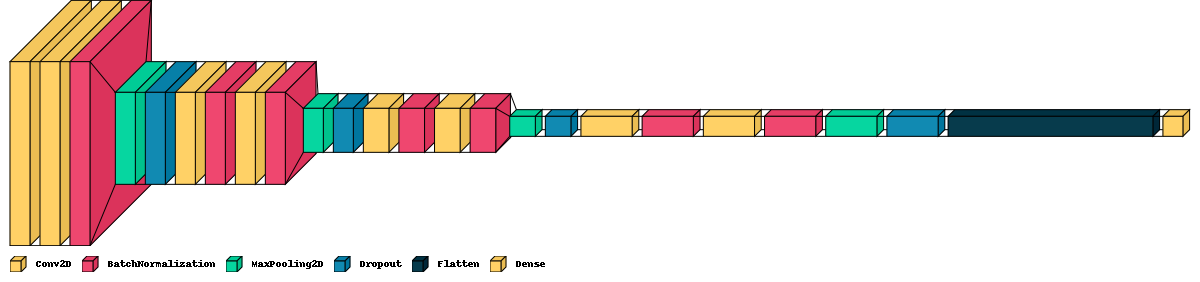

In [ ]:
#visual representation of the architecture
layered_view(model_fer_3,legend=True)

In [ ]:
#compiling the model
opt=tf.keras.optimizers.Adam(lr=0.0001,decay=1e-6)
model_fer_3.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#fitting the model
num_epochs = 200
early_stopping=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)#early stopping upon no improvement over 15 epochs
history = model_fer_3.fit(train_flow, 
                    steps_per_epoch=len(x_train) / 64, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=val_flow,
                    callbacks=[early_stopping])


Epoch 1/200
448/448 [==============================] - 22s 46ms/step - loss: 2.6514 - accuracy: 0.2192 - val_loss: 1.9311 - val_accuracy: 0.2513
Epoch 2/200
448/448 [==============================] - 20s 46ms/step - loss: 2.1486 - accuracy: 0.2500 - val_loss: 1.7557 - val_accuracy: 0.3018
Epoch 3/200
448/448 [==============================] - 20s 45ms/step - loss: 1.9605 - accuracy: 0.2895 - val_loss: 1.6711 - val_accuracy: 0.3611
Epoch 4/200
448/448 [==============================] - 21s 46ms/step - loss: 1.7847 - accuracy: 0.3305 - val_loss: 1.7944 - val_accuracy: 0.3263
Epoch 5/200
448/448 [==============================] - 22s 50ms/step - loss: 1.6238 - accuracy: 0.3785 - val_loss: 1.5803 - val_accuracy: 0.4009
Epoch 6/200
448/448 [==============================] - 21s 46ms/step - loss: 1.5231 - accuracy: 0.4172 - val_loss: 1.5086 - val_accuracy: 0.4349
Epoch 7/200
448/448 [==============================] - 20s 45ms/step - loss: 1.4449 - accuracy: 0.4502 - val_loss: 1.3703 - val_ac

In [90]:
model_json = model_fer_3.to_json()
with open("model_fer_3.json", "w") as json_file:
    json_file.write(model_json)
model_fer_3.save_weights("model_fer_3.h5")
print("Saved model to disk")

Saved model to disk


In [99]:
#total loss and accuracy in training the dataset on test set
score = model_fer_3.evaluate(x_test/255., y_test, verbose=1) 
print("Test Loss: ", (score[0]))
print("Test Accuracy: ",  score[1]*100)

113/113 [==============================] - 2s 11ms/step - loss: 0.8991 - accuracy: 0.6709
Test Loss:  0.8991346955299377
Test Accuracy:  67.09389686584473


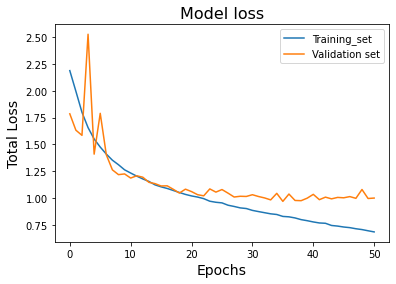

In [ ]:
plt.plot(history.history['loss'], label="Training_set")
plt.plot(history.history['val_loss'], label="Validation set")
plt.title("Model loss", size=16)
plt.ylabel("Total Loss", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

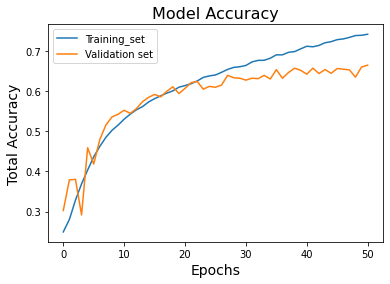

In [ ]:
plt.plot(history.history['accuracy'], label="Training_set")
plt.plot(history.history['val_accuracy'], label="Validation set")
plt.title("Model Accuracy", size=16)
plt.ylabel("Total Accuracy", size=14)
plt.xlabel("Epochs", size=14)
plt.legend()
plt.show()

In [112]:
from tensorflow.keras.models import model_from_json
model = model_from_json(open('/content/model_fer_3.json').read())
model.load_weights('/content/model_fer_4.h5')
opt=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [114]:
from keras.preprocessing import image
def pred_emotion(img_path):
  emotion_dict = {0: 'Angry', 1: 'Disgusted', 2: 'Fearful', 3: 'Happy', 4: 'Sad',5: 'Surprised', 6: 'Neutral'}
  img = image.load_img(img_path, color_mode='grayscale', target_size=(48,48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  prediction = np.argmax(model.predict(x))
  print('The predicted emotion is : ' + emotion_dict[prediction])
  my_image = image.load_img(img_path)
  plt.imshow(my_image)
  result = plt.show()
  return result

The predicted emotion is : Happy


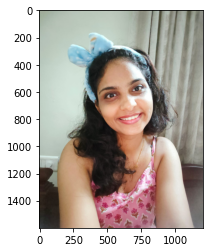

In [101]:
pred_emotion("/content/drive/MyDrive/Cloudy ML/opencv/happy aishu2.jfif")

The predicted emotion is : Angry


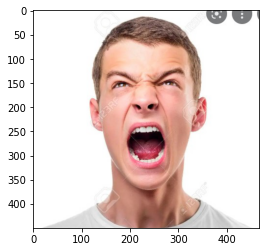

In [115]:
pred_emotion('/content/drive/MyDrive/Cloudy ML/opencv/angry.jpg')

113/113 [==============================] - 59s 524ms/step


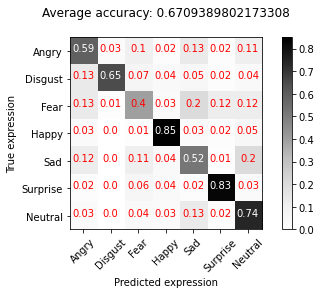

In [ ]:
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
import itertools 
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "red")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(x_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

The model accuracy has improved after tweaking the dropout parameters. This stands as our best model in hand.

Improving the model further, would require more data. And implimenting transfer learning might help as well. 

This would be included in the future scope of the project.

We can go ahead and deploy the web app now.

Following are some detection made using the web application developed using model_fer_3